# Potrzebne biblioteki

In [96]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from itertools import product
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle



# Wczytanie danych 

In [27]:

adult = pd.read_csv('data/adult-all.csv', header=None, delimiter=',')
adult.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Przygotowanie danych

### Dane z brakującymi informacjami

In [28]:
missing_rows = (adult == '?').any(axis=1).sum()

print(f'Liczba wierszy z brakującymi informacji: {missing_rows}')

total_rows = adult.shape[0]

print(f'Liczba wszystkich wierszy: {total_rows}')

Liczba wierszy z brakującymi informacji: 3620
Liczba wszystkich wierszy: 48842


Ze względu na fakt, iż wierszy z brakującymi danymi jest mało w porównaniu do ich całkowitej ilośći, zdecydowano aby je usunąć.

In [29]:
adult.replace('?', np.nan, inplace=True)

adult = adult.dropna()

adult.shape

(45222, 15)

### Usówanie duplikatów

In [30]:
adult = adult.drop_duplicates()

adult.shape

(45175, 15)

### Zamiana wartości kategorycznych na numeryczne

In [31]:
categorical_columns = [1, 3, 5, 6, 7, 8, 9, 13]

label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    adult[column] = le.fit_transform(adult[column])
    label_encoders[column] = le

print(adult.head())

   0   1       2   3   4   5   6   7   8   9     10  11  12  13     14
0  39   5   77516   9  13   4   0   1   4   1  2174   0  40  38  <=50K
1  50   4   83311   9  13   2   3   0   4   1     0   0  13  38  <=50K
2  38   2  215646  11   9   0   5   1   4   1     0   0  40  38  <=50K
3  53   2  234721   1   7   2   5   0   2   1     0   0  40  38  <=50K
4  28   2  338409   9  13   2   9   5   2   0     0   0  40   4  <=50K


# Trenowanie klasyfikatorów 

In [71]:
# Podział na cechy i etykiety
X = adult.drop(columns=[14])
y = adult[14]

# Parametry do przetestowania
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Klasyfikatory
classifiers = {
    'RandomForest': RandomForestClassifier(),
    'ExtraTrees': ExtraTreesClassifier()
}

# Wyniki - najlepsze parametry i wszystkie kombinacje
results = {}
all_combinations = {clf_name: [] for clf_name in classifiers.keys()}

# Ustalanie nieobciążonej dokładności, precyzji i czułości oraz ich odchylenia standardowego
for clf_name, clf in classifiers.items():
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
    
    accuracies = []
    precisions = []
    recalls = []
    
    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        grid_search = GridSearchCV(clf, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1, return_train_score=True)
        grid_search.fit(X_train, y_train)
        best_clf = grid_search.best_estimator_
        
        accuracies.append(best_clf.score(X_test, y_test))
        precisions.append(precision_score(y_test, best_clf.predict(X_test), average='weighted'))
        recalls.append(recall_score(y_test, best_clf.predict(X_test), average='weighted'))
        
        # Zapis wszystkich wyników kombinacji parametrów
        for i, params in enumerate(grid_search.cv_results_['params']):
            all_combinations[clf_name].append({
                'params': params,
                'mean_train_score': grid_search.cv_results_['mean_train_score'][i],
                'std_train_score': grid_search.cv_results_['std_train_score'][i],
                'mean_test_score': grid_search.cv_results_['mean_test_score'][i],
                'std_test_score': grid_search.cv_results_['std_test_score'][i],
            })
    
    results[clf_name] = {
        'best_params': grid_search.best_params_,
        'accuracy': np.mean(accuracies),
        'precision': np.mean(precisions),
        'recall': np.mean(recalls),
        'accuracy_std': np.std(accuracies),
        'precision_std': np.std(precisions),
        'recall_std': np.std(recalls),
    }

c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
81 fits failed out of a total of 243.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_p

In [76]:
for clf_name, combinations in all_combinations.items():
        print(f"Results for all combinations of parameters for {clf_name}:")
        for idx, combination in enumerate(combinations, start=1):
            if all(not pd.isna(val) for val in combination.values()):
                print(f"Combination {idx}: {combination}")

Results for all combinations of parameters for RandomForest:
Combination 28: {'params': {'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}, 'mean_train_score': 0.9994687220479337, 'std_train_score': 6.21111801657087e-05, 'mean_test_score': 0.8472239166500168, 'std_test_score': 0.003345990793185192}
Combination 29: {'params': {'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, 'mean_train_score': 0.9999833972539057, 'std_train_score': 2.3479828699054755e-05, 'mean_test_score': 0.8484193044483227, 'std_test_score': 0.003547939087417108}
Combination 30: {'params': {'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}, 'mean_train_score': 0.9999833972539057, 'std_train_score': 2.3479828699054755e-05, 'mean_test_score': 0.849714290530463, 'std_test_score': 0.003188813606530938}
Combination 31: {'params': {'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split'

In [73]:
# Wypisanie najlepszych wyników
for clf_name, clf_results in results.items():
    print(f"{clf_name} - Best Params: {clf_results['best_params']}")
    print(f"Accuracy: {clf_results['accuracy']} +/- {clf_results['accuracy_std']}")
    print(f"Precision: {clf_results['precision']} +/- {clf_results['precision_std']}")
    print(f"Recall: {clf_results['recall']} +/- {clf_results['recall_std']}")
    print()

RandomForest - Best Params: {'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 150}
Accuracy: 0.8596346805882548 +/- 0.0029931864964266993
Precision: 0.8542903176593916 +/- 0.003265488834189473
Recall: 0.8596346805882548 +/- 0.0029931864964266993

ExtraTrees - Best Params: {'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.8548532514189632 +/- 0.0031307097773160156
Precision: 0.8489901280788731 +/- 0.0033751827984222884
Recall: 0.8548532514189632 +/- 0.0031307097773160156



In [56]:
# Analiza istotności cech
feature_importances = {}
for clf_name, clf in classifiers.items():
    clf.fit(X, y)
    feature_importances[clf_name] = clf.feature_importances_


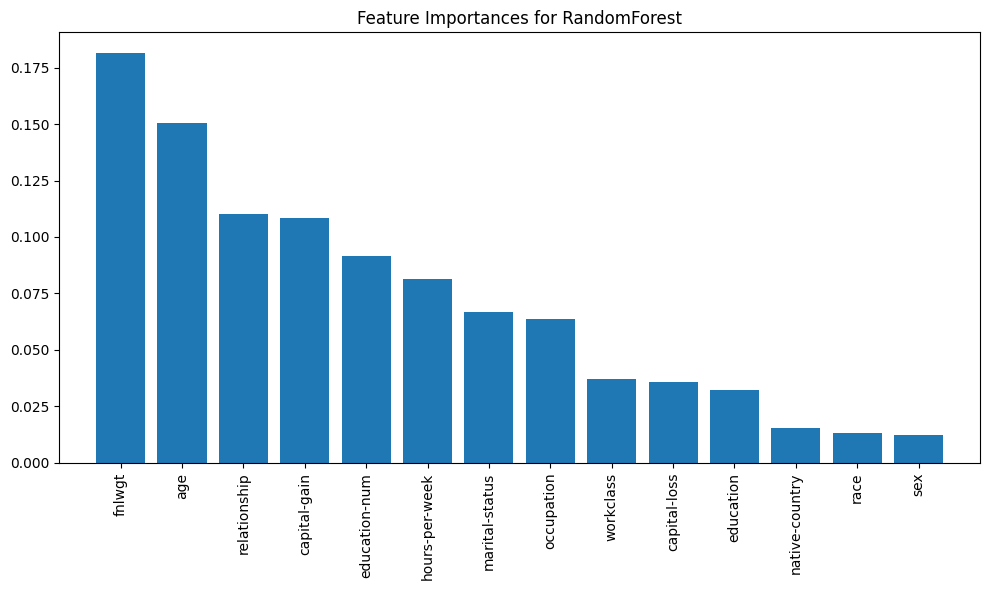

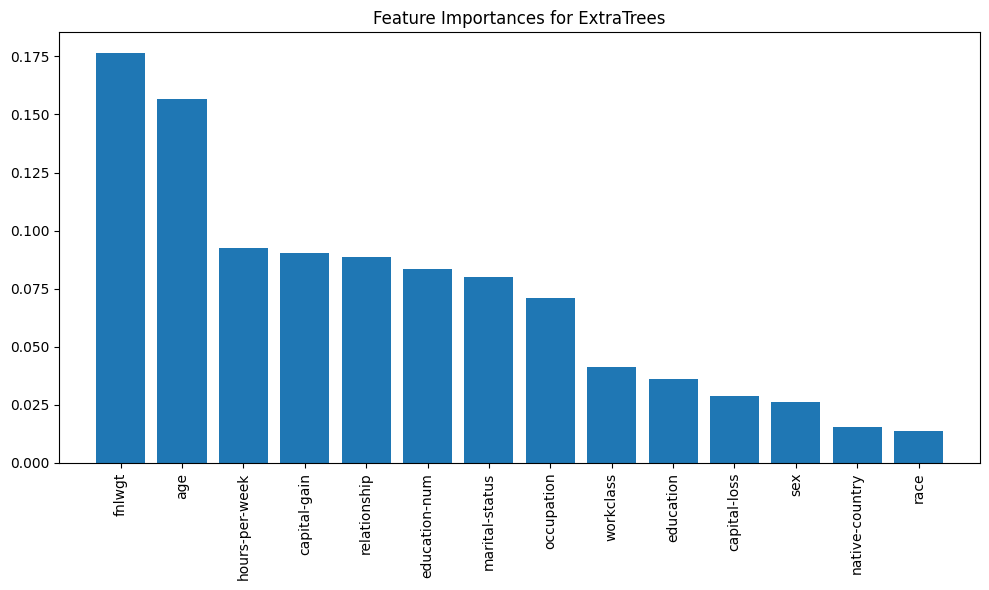

In [70]:
# Tworzenie wykresów
feature_names = ["age", "workclass", "fnlwgt", "education", "education-num", 
                 "marital-status", "occupation", "relationship", "race", "sex", 
                 "capital-gain", "capital-loss", "hours-per-week", "native-country"]


for clf_name, importances in feature_importances.items():
    indices = np.argsort(importances)[::-1]  
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances for {clf_name}")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.tight_layout()
    plt.show()



if isinstance(results, dict):
    for clf_name, clf_results in results.items():
        print(f"{clf_name} - Best Params: {clf_results['best_params']}")
        print(f"Accuracy: {clf_results['accuracy']} +/- {clf_results['accuracy_std']}")
        print(f"Precision: {clf_results['precision']} +/- {clf_results['precision_std']}")
        print(f"Recall: {clf_results['recall']} +/- {clf_results['recall_std']}")
        print()
else:
    print("")

# Krzywa ROC

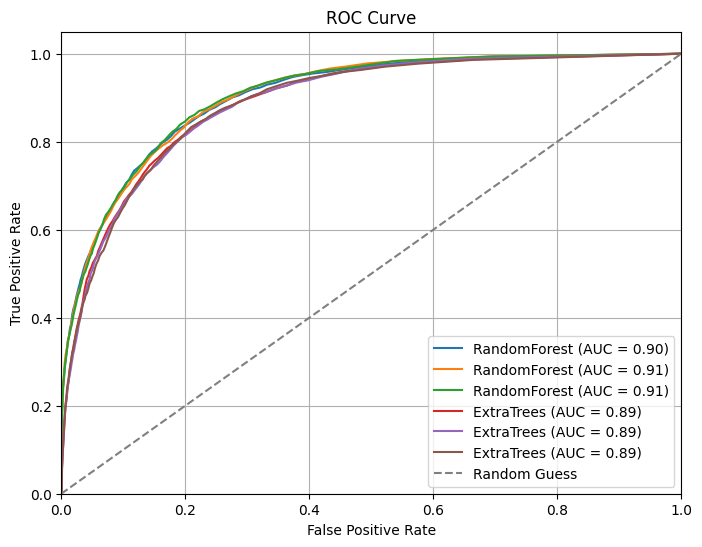

In [98]:
# Ustawienie progu czułości dla oceny pewności siebie klasyfikatora (np. 0.5)
sensitivity_threshold = 0.5

# Funkcja do obliczenia i wykreslenia krzywej ROC dla danego klasyfikatora
def plot_roc_curve(clf_name, clf, X_test, y_test):
    y_score = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

# Przekształcenie etykiet klas na wartości binarne
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Obliczenie i wykreslenie krzywych ROC dla obu klasyfikatorów
plt.figure(figsize=(8, 6))
for clf_name, clf in classifiers.items():
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)
    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]  # Użyj przekształconych etykiet
        clf.fit(X_train, y_train)
        plot_roc_curve(clf_name, clf, X_test, y_test)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.legend()
plt.show()